In [ ]:
from n_framework import*
from activations_module import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3AE92490-D363-3FD7-8532-CB6F5F795BC8> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## SGD

In [ ]:
class SGD:
    def __init__(self,params,lr,wd=0.):
        params= list(params)
        fc.store_attr()
        self.i =0
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1
        
    def opt_step(self,p): p -= p.grad* self.lr
    def reg_step(self,p): 
        if self.wd !=0: p *= 1 - self.lr*self.wd
            
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()
     

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model,dls, F.cross_entropy,lr=0.4,cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.761,0.679,0,train
0.816,0.500,0,eval
0.839,0.439,1,train
0.836,0.443,1,eval
0.856,0.390,2,train
0.851,0.409,2,eval


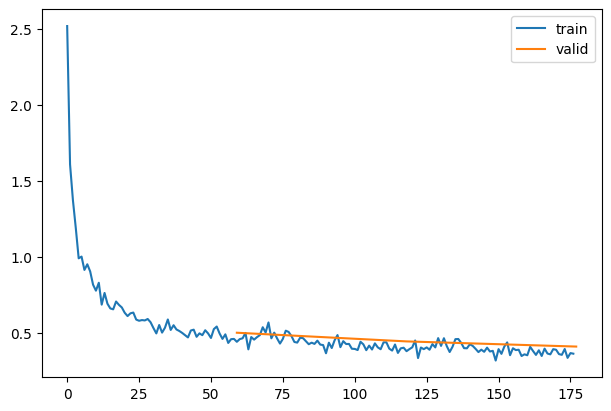

In [ ]:
learn.fit(3)

In [ ]:
class Momentum(SGD):
    def __init__(self,params,lr,wd=0.,mom=0.9):
        super().__init__(params,lr=lr,wd=wd)
        self.mom=mom
        
    def opt_step(self,p):
        if not hasattr(p,'grad_avg'): p.grad_avg= torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -=p.grad_avg*self.lr

In [ ]:
set_seed(42)
model =get_model(act_gr,norm = nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model,dls,F.cross_entropy,lr=1.5,cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.774,0.629,0,train
0.846,0.425,0,eval
0.865,0.366,1,train
0.868,0.366,1,eval
0.884,0.317,2,train
0.877,0.341,2,eval


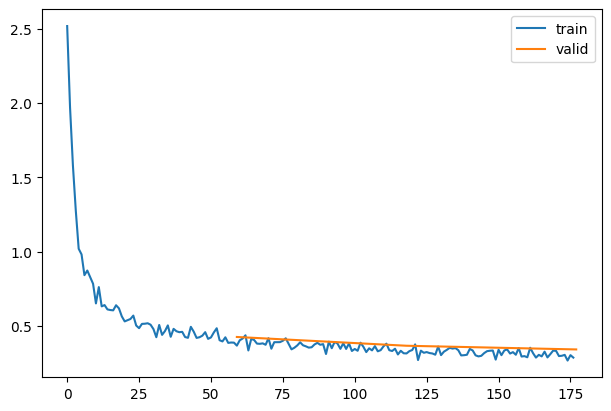

CPU times: user 1min 48s, sys: 2.39 s, total: 1min 50s
Wall time: 48.8 s


In [ ]:
%time learn.fit(3)

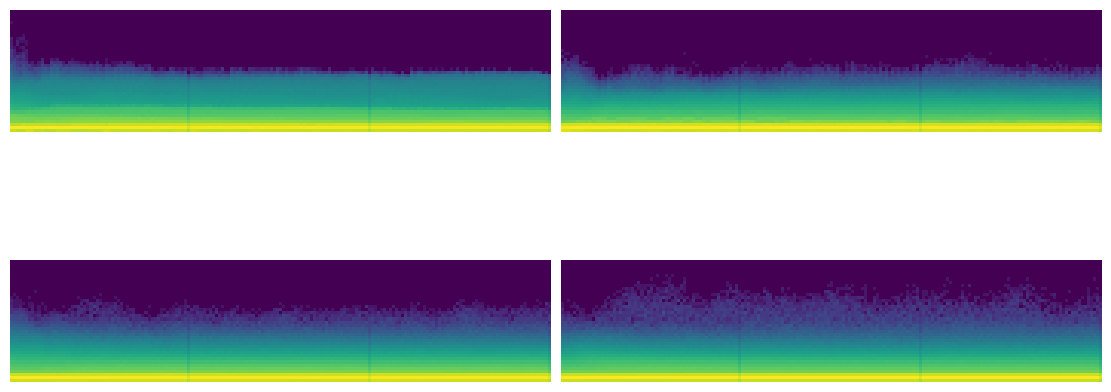

In [ ]:
astats.color_dim()

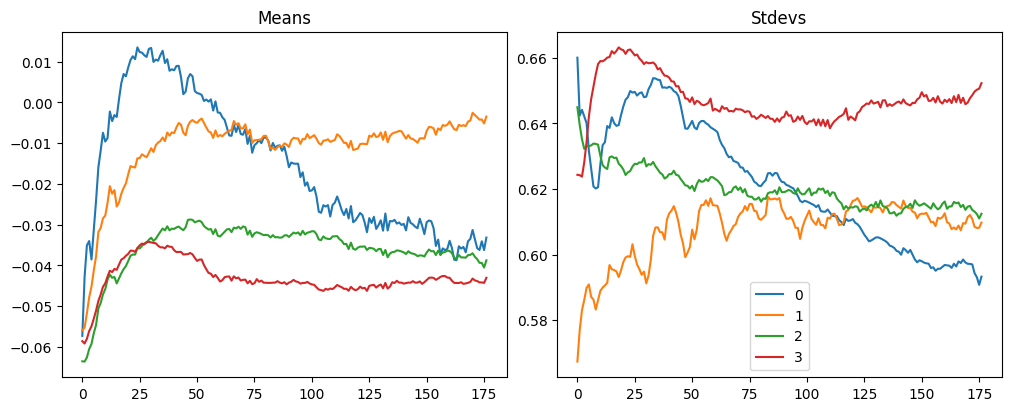

In [ ]:
astats.plot_stats()

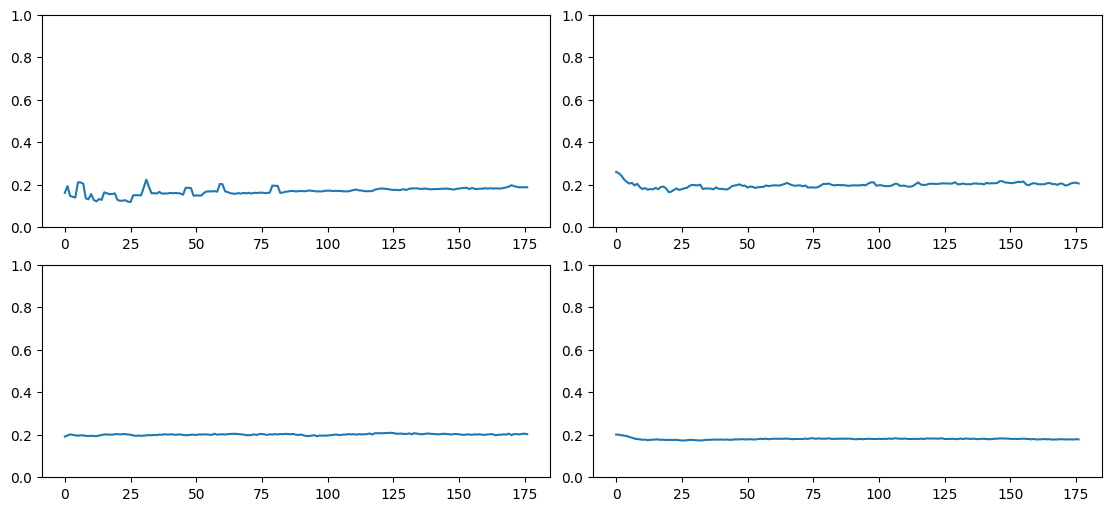

In [ ]:
astats.dead_chart()

In [ ]:
class RMSProp(SGD):
    def __init__(self,params,lr,wd=0.,sqr_mom=0.99, eps=1e-5):
        super().__init__(params,lr=lr,wd=wd)
        self.sqr_mom,self.eps=sqr_mom,eps
        
    def opt_step(self,p):
        if not hasattr(p,'sqr_avg'): p.sqr_avg= p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        upd = p.grad / (p.sqr_avg.sqrt()+ self.eps)
        p -=self.lr*upd

In [ ]:
set_seed(42)
model =get_model(act_gr,norm = nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model,dls,F.cross_entropy,lr=3e-3,cbs=cbs, opt_func=RMSProp)

accuracy,loss,epoch,train
0.765,0.675,0,train
0.822,0.494,0,eval
0.847,0.420,1,train
0.831,0.452,1,eval
0.864,0.371,2,train
0.851,0.410,2,eval


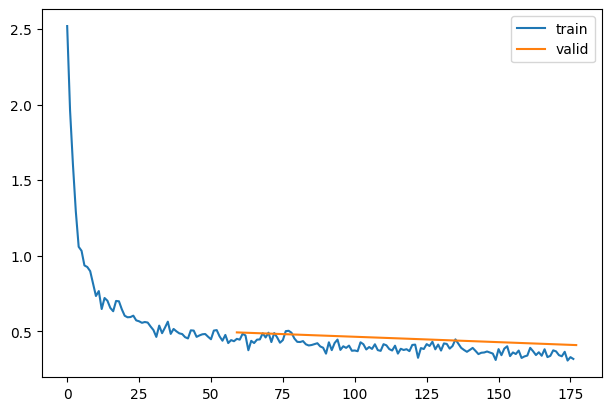

CPU times: user 1min 49s, sys: 2.58 s, total: 1min 52s
Wall time: 48.3 s


In [ ]:
%time learn.fit(3)

In [ ]:
clean_mem()

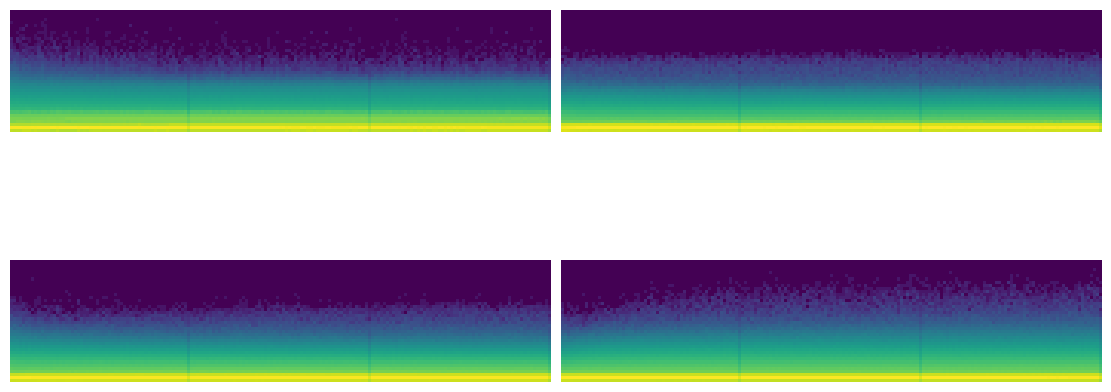

In [ ]:
astats.color_dim()

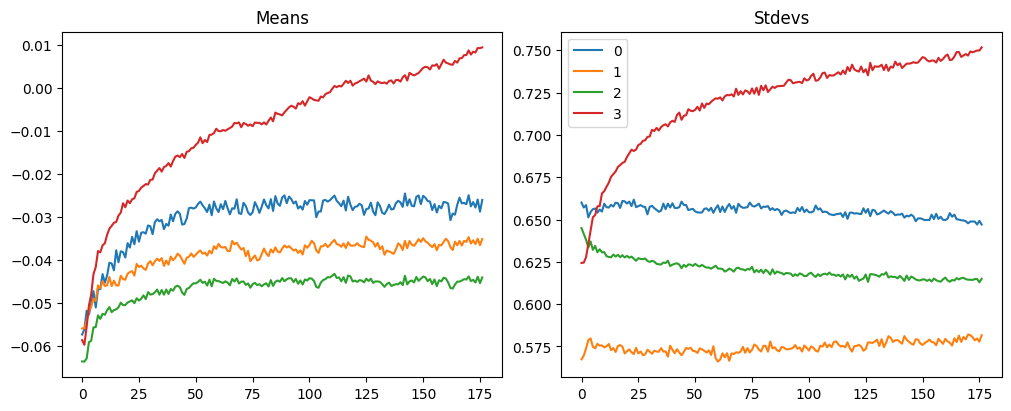

In [ ]:
astats.plot_stats()

In [ ]:
class ADAM(SGD):
    def __init__(self,params,lr, wd=0., beta1=0.9,beta2=0.99,eps=1e-5):
        super().__init__(params,lr=lr,wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps
        
    def one_step(self,p):
        if not hasattr(p,'avg'): p.grad = torch.zeros_like(p.grad.data)
        if not hasattr(p,'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1 *p.avg + (1-self.beta1)*p.grad
        unbiaz_avg = p.avg / (1 - (self.beta1 **(self.i+1)))
        p.sqr_avg = self.beta2 *p.sqr_avg + (1 - self.beta2)* (p.grad**2)
        unbiaz_sqr_avg = p.sqr_avg / (1 - (self.beta2 **(self.i+1)))
        p -= self.lr * unbiaz_avg / (unbiaz_sqr_avg +self.eps).sqrt()

accuracy,loss,epoch,train
0.761,0.679,0,train
0.816,0.500,0,eval
0.839,0.439,1,train
0.836,0.443,1,eval
0.856,0.390,2,train
0.851,0.409,2,eval


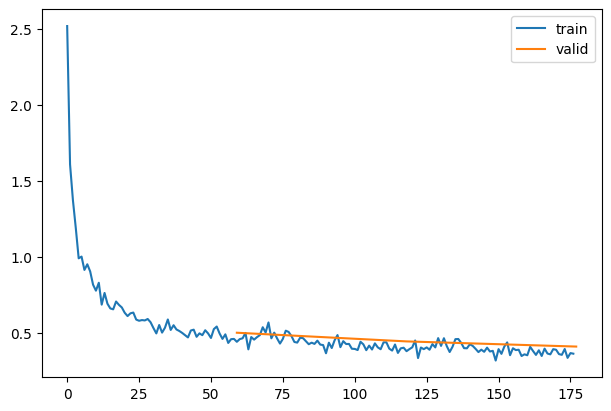

CPU times: user 1min 50s, sys: 2.37 s, total: 1min 52s
Wall time: 50.7 s


In [ ]:
set_seed(42)
model = get_model(act_gr, norm = nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model,dls, F.cross_entropy,lr=0.4,cbs=cbs, opt_func=ADAM)
%time learn.fit(3)

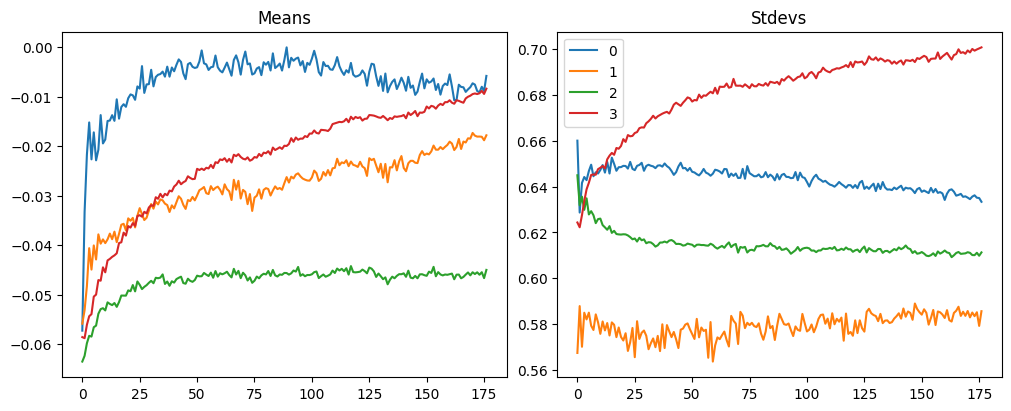

In [ ]:
astats.plot_stats()

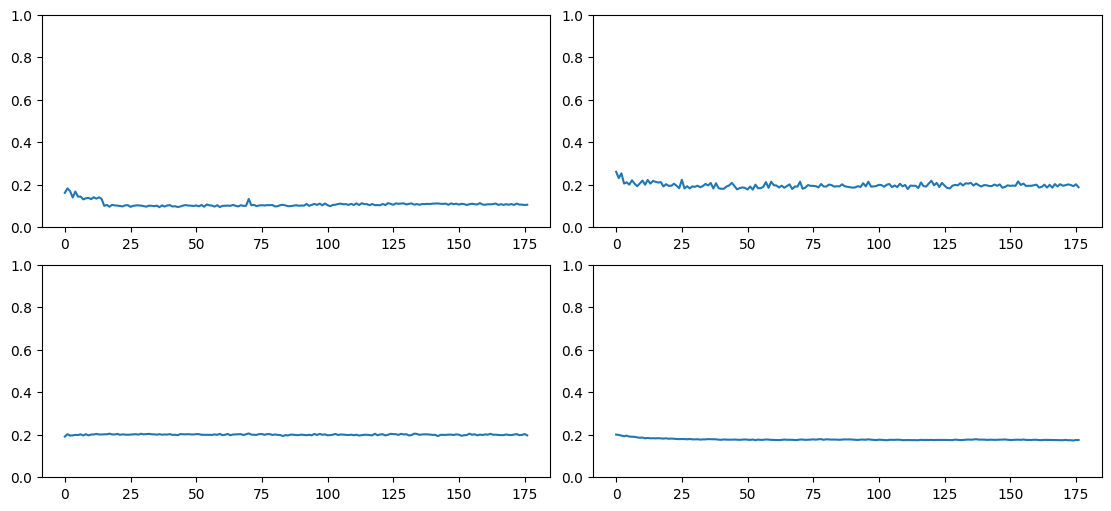

In [ ]:
astats.dead_chart()

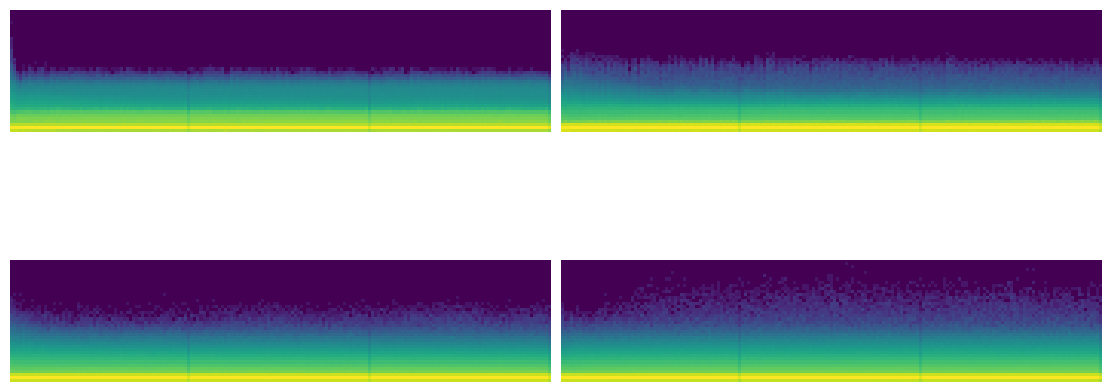

In [ ]:
astats.color_dim()

In [ ]:
clean_mem()

## Scheduler

* we are going to use pytorch lr schedulor and optimizers not our custom optimizers[above ..adam,RMSPROP]

In [ ]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [ ]:
' '.join(filter(lambda x:x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [ ]:
from fastcore.basics import Self as X

In [ ]:
' '.join(filter(X[0].isupper() and X[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR _enable_get_lr_call bisect_right inf math partial types warnings weakref wraps'

In [ ]:
learn = TrainLearner(get_model(),dls,F.cross_entropy,lr=6e-3, cbs = [DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [ ]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'OptimizerPostHook OptimizerPreHook add_param_group defaults load_state_dict param_groups profile_hook_step register_load_state_dict_post_hook register_load_state_dict_pre_hook register_state_dict_post_hook register_state_dict_pre_hook register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [ ]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [ ]:
opt.state

defaultdict(dict,
            {Parameter containing:
             tensor([[[[ 0.28,  0.01,  0.06],
                       [-0.33,  0.06, -0.08],
                       [ 0.25, -0.01,  0.02]]],
             
             
                     [[[-0.11,  0.20, -0.20],
                       [ 0.18,  0.06, -0.18],
                       [ 0.30,  0.04, -0.06]]],
             
             
                     [[[ 0.04, -0.13, -0.18],
                       [ 0.22,  0.28, -0.15],
                       [ 0.11, -0.22, -0.15]]],
             
             
                     [[[-0.31,  0.19, -0.20],
                       [-0.05,  0.15, -0.20],
                       [-0.23,  0.25, -0.04]]],
             
             
                     [[[-0.22,  0.03,  0.07],
                       [-0.15, -0.15, -0.14],
                       [ 0.03, -0.03, -0.24]]],
             
             
                     [[[ 0.24,  0.12,  0.29],
                       [-0.32,  0.08,  0.27],
               

In [ ]:
param

Parameter containing:
tensor([[[[ 0.28,  0.01,  0.06],
          [-0.33,  0.06, -0.08],
          [ 0.25, -0.01,  0.02]]],


        [[[-0.11,  0.20, -0.20],
          [ 0.18,  0.06, -0.18],
          [ 0.30,  0.04, -0.06]]],


        [[[ 0.04, -0.13, -0.18],
          [ 0.22,  0.28, -0.15],
          [ 0.11, -0.22, -0.15]]],


        [[[-0.31,  0.19, -0.20],
          [-0.05,  0.15, -0.20],
          [-0.23,  0.25, -0.04]]],


        [[[-0.22,  0.03,  0.07],
          [-0.15, -0.15, -0.14],
          [ 0.03, -0.03, -0.24]]],


        [[[ 0.24,  0.12,  0.29],
          [-0.32,  0.08,  0.27],
          [-0.28,  0.26, -0.22]]],


        [[[ 0.20, -0.10,  0.08],
          [-0.25,  0.00, -0.07],
          [ 0.28, -0.23,  0.18]]],


        [[[-0.25, -0.05, -0.24],
          [ 0.23, -0.00,  0.14],
          [ 0.07, -0.00,  0.07]]]], device='mps:0', requires_grad=True)

In [ ]:
st

{'momentum_buffer': None}

In [ ]:
len(opt.param_groups)

1

In [ ]:
pg = opt.param_groups[0]

In [ ]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [ ]:
sched = lr_scheduler.CosineAnnealingLR(opt,100)

In [ ]:
sched.base_lrs

[0.006]

In [ ]:
sched.get_last_lr()

[0.006]

In [ ]:
def sched_lrs(sched,steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

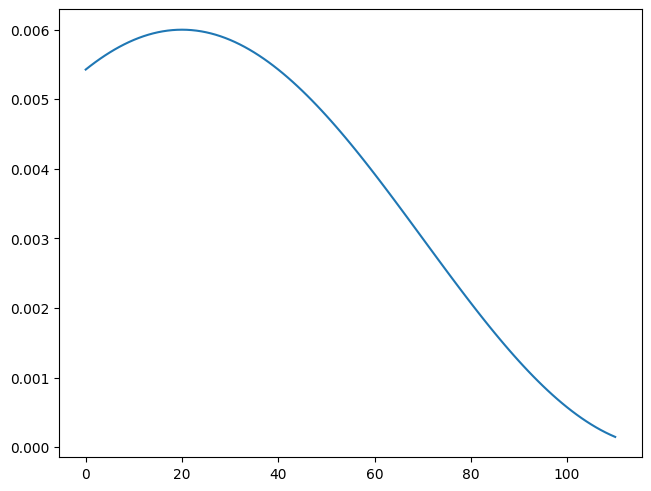

In [ ]:
sched_lrs(sched,110)

## scheduler callback

In [ ]:
#|export
class BaseschedulerCB(callback):
    def __init__(self,sched): self.sched = sched
    def before_fit(self,learn): self.schedo = self.sched(learn.opt)
    def step(self,learn):
        if learn.training: self.schedo.step()

In [ ]:
#|export
class BatchschedCB(BaseschedulerCB):
    def after_batch(self,learn): self.step(learn)

In [ ]:
#|export
class HasLearnCB(callback):
    def before_fit(self,learn): self.learn = learn
    def after_fit(self,learn): self.learn = None

In [ ]:
#|export
class RecorderCB(callback):
    def __init__(self, **d): self.d = d
    def before_fit(self,learn):
            self.recs = {k:[] for k in self.d}
            self.pg = learn.opt.param_groups[0]
            
    def after_batch(self,learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))
    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v,label=k)
            plt.legend()
            plt.show()

In [ ]:
def _lr(cb): return cb.pg['lr']

In [ ]:
len(dls.train)

59

In [ ]:
tmax = 3* len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max = tmax)

accuracy,loss,epoch,train
0.802,0.546,0,train
0.859,0.390,0,eval
0.879,0.331,1,train
0.872,0.348,1,eval
0.896,0.285,2,train
0.880,0.327,2,eval


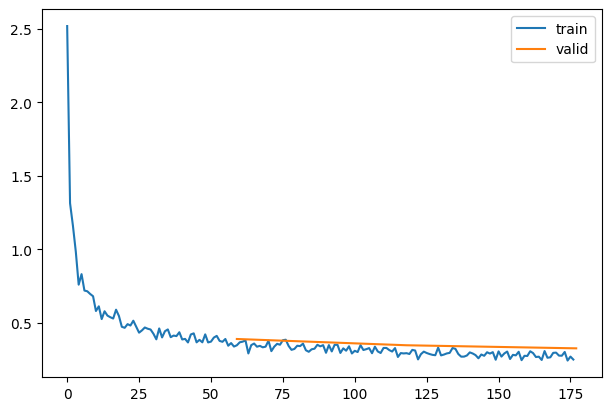

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchschedCB(sched),rec]
learn = TrainLearner(model,dls, F.cross_entropy,lr=2e-2, cbs = cbs+xtra, opt_func= optim.AdamW)
learn.fit(3)

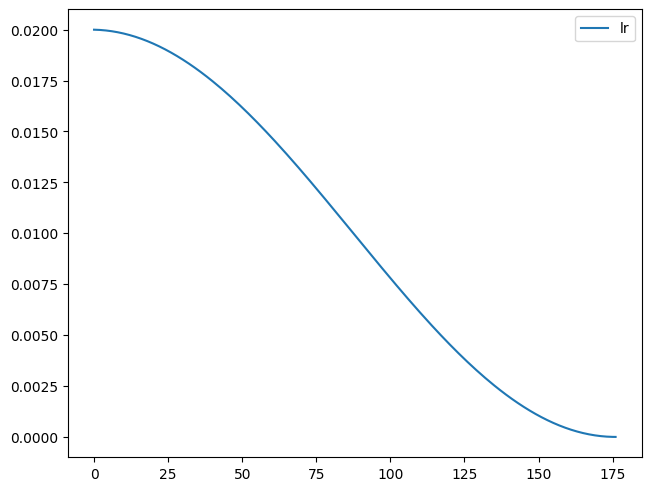

In [ ]:
rec.plot()

In [ ]:
#|export
class EpochSchedCB(BaseschedulerCB):
    def after_epoch(self,learn): self.step(learn)

accuracy,loss,epoch,train
0.801,0.547,0,train
0.855,0.401,0,eval
0.879,0.332,1,train
0.875,0.343,1,eval
0.898,0.279,2,train
0.883,0.321,2,eval


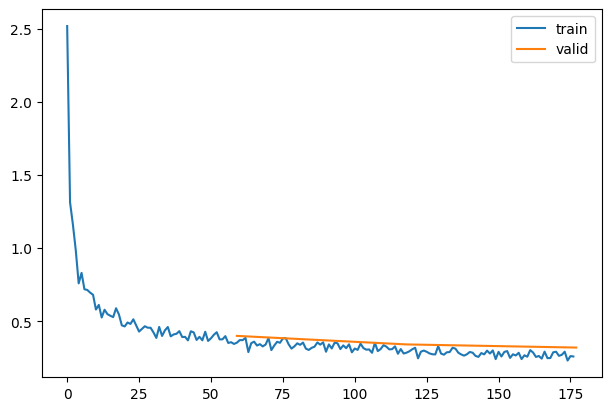

In [ ]:
sched = partial(lr_scheduler.CosineAnnealingLR,T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model,dls,F.cross_entropy,lr = 2e-2,cbs = cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

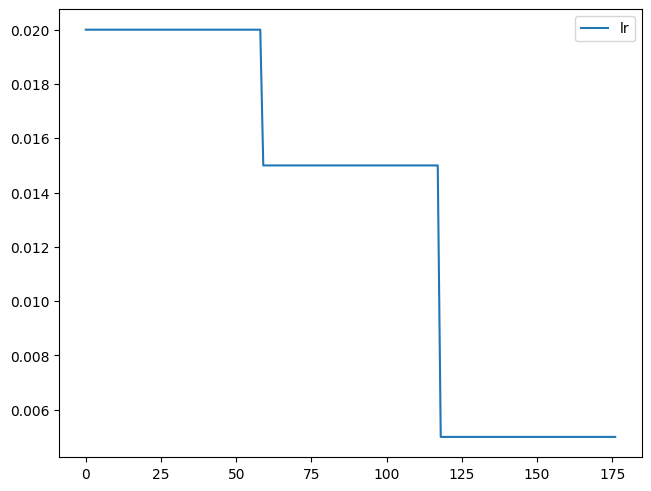

In [ ]:
rec.plot()

### Once cycle Training 

In [ ]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.756,0.699,0,train
0.845,0.507,0,eval
0.862,0.377,1,train
0.855,0.420,1,eval
0.885,0.313,2,train
0.876,0.356,2,eval
0.902,0.264,3,train
0.890,0.297,3,eval
0.919,0.219,4,train
0.900,0.279,4,eval


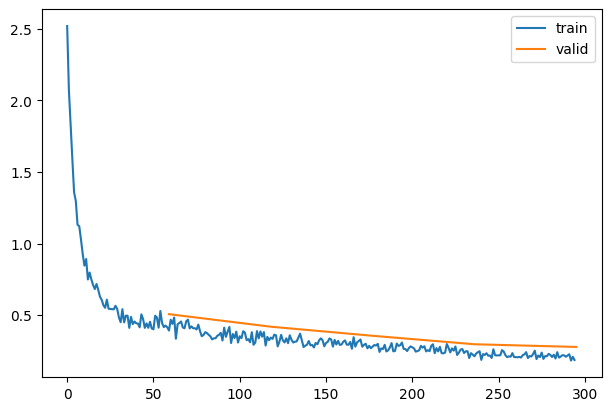

In [ ]:
set_seed(42)
lr,epochs=5.7e-2,5
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR,max_lr=lr, total_steps = tmax)
xtra=[BatchschedCB(sched),rec]
learn = TrainLearner(model,dls,F.cross_entropy,lr=lr, cbs=cbs+xtra,opt_func=optim.AdamW)
learn.fit(epochs)

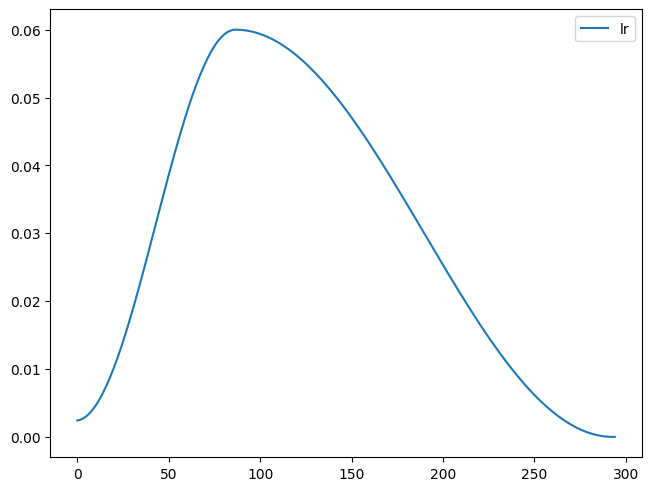

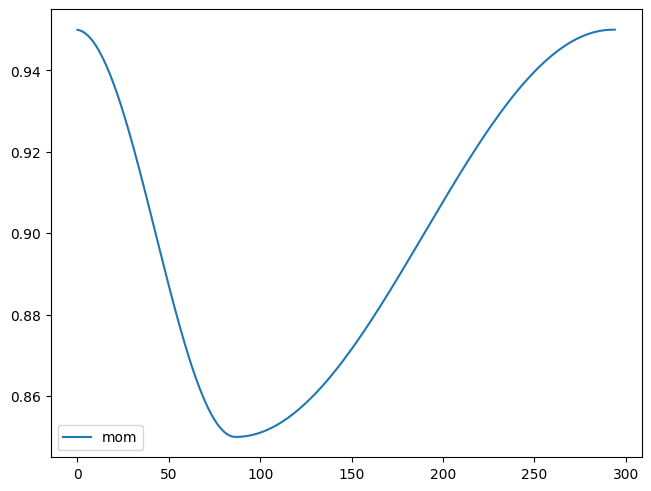

In [ ]:
rec.plot()

In [ ]:
clean_mem()

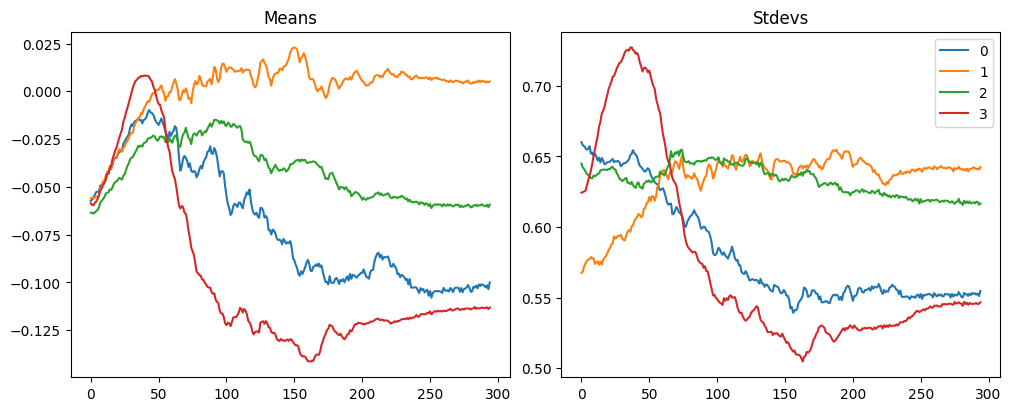

In [ ]:
astats.plot_stats()

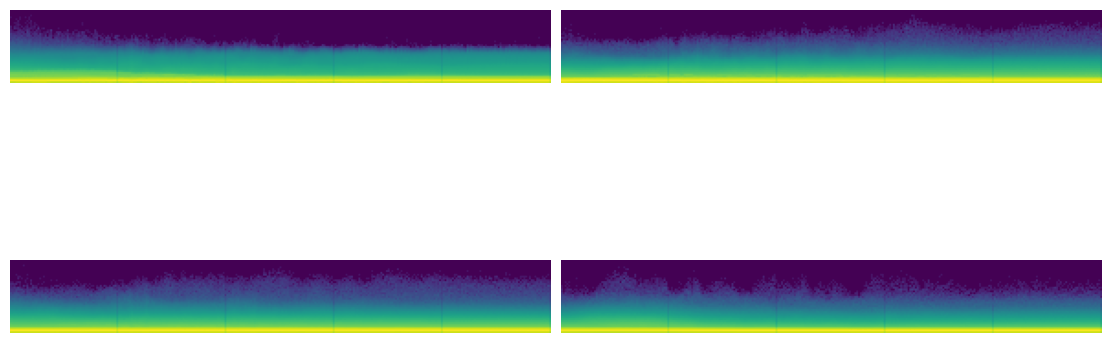

In [ ]:
astats.color_dim()